# Hands-on GNN-based models for User Profiling (2/2) - **RHGN**

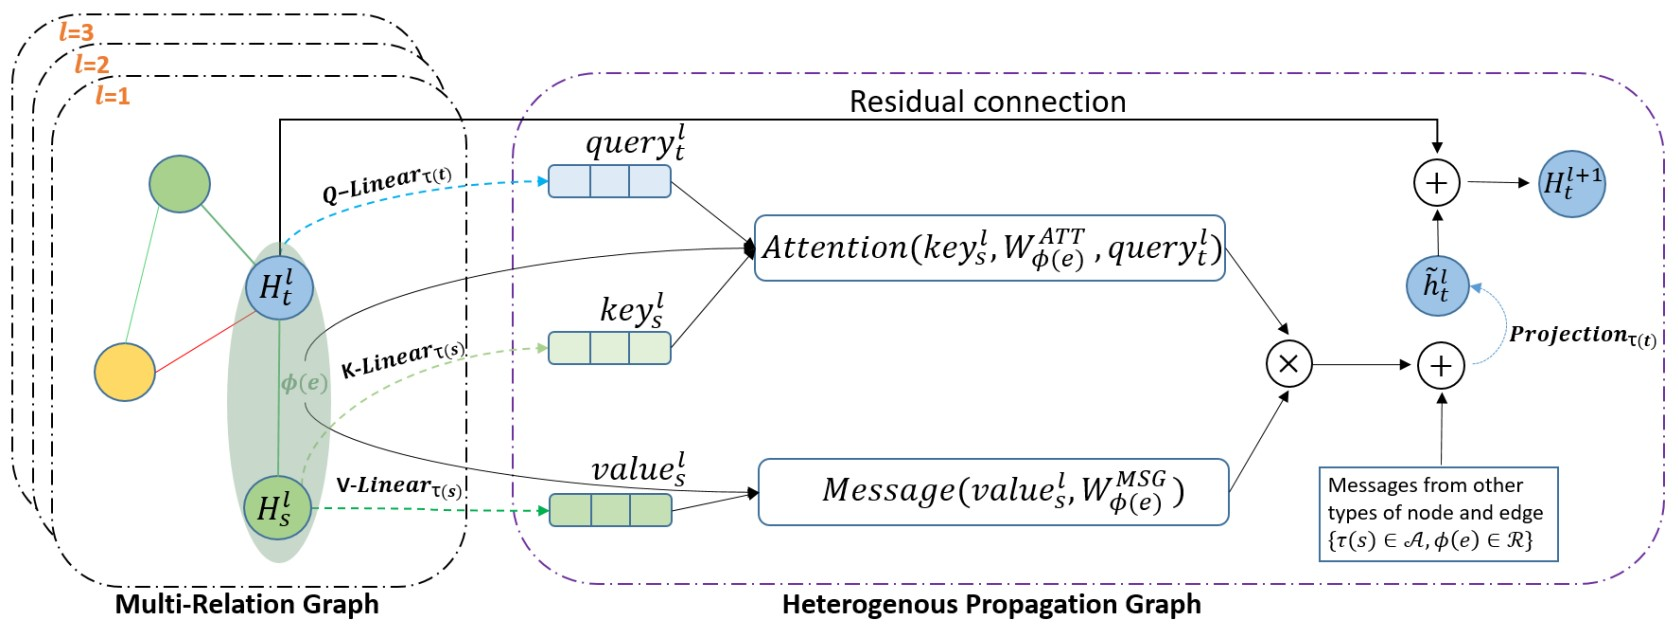

**RHGN** [(Yan et al., 2021)](https://arxiv.org/pdf/2110.07181.pdf) is a *Relation-aware Heterogeneous Graph Network* designed to model multiple relations on a heterogeneous graph between different kinds of entities.

The core parts of this model are a transformer-like multi-relation attention, used to learn the node importance and uncover the meta-relation significance on
the graph, and a heterogeneous graph propagation network employed to gather information from multiple sources.

This approach outperforms several GNN-based models on user profiling tasks.

---
## Get started

If you joined the Tutorial session late... Let's prepare our **workspace**!

The material is included in the [GitHub repository](https://github.com/beyondaccuracy-userprofiling/tutorial-umap23) of the tutorial (expect for the raw datasets, due to upload limits of GitHub).

⭐ Star the repository if you are interested in this tutorial and its future updated versions.

To get started with the hands-on, follow these steps:

* Open the [Google Drive folder](https://drive.google.com/drive/folders/1bNDrHaqmvQH8iiNcbMnetYgcq6y3roGM?usp=sharing) containing all the needed resources;
* Click on the folder name (*Hands-on*) and select *Add shortcut to Drive*;
* On the left, go to **My Drive**, locate the *Hands-on* folder;
* Open the notebook named *2_RHGN.ipynb* (and all the others for the next hands-on sessions);
* On the top, open the *Runtime* tab, click on *Change runtime type* and select **GPU** as the *Harware Acceleration*, to enable the execution of this notebook on a GPU (required for the GNN training).

### Mount the Drive

The first operation is to allow the notebook to access the hands-on files downloaded in your personal Google Drive folder.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now that you have your Google Drive mounted, let's set the base directory path as the tutorial's folder.

In [2]:
base_path = "/content/drive/MyDrive/Code/personal_projects/tutorial-umap23/Hands-on"

---
## Utilities

*Every operation will be described in order to make this tutorial also enjoyable by beginners and anyone not familiar with all the packages imported.*

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Install missing libraries
!pip install dgl -f https://data.dgl.ai/wheels/cu118/repo.html

import pandas as pd
import numpy as np
import os
import pickle
import torch
import dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/cu118/repo.html


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Utilities to visualize the **information** and **statistics** of a *DataFrame*.

In [4]:
def show_df_info(df):
    print(df.info())
    print('####### Repeat ####### \n', df.duplicated().any())
    print('####### Count ####### \n', df.nunique())
    print('####### Example ####### \n',df.head())

In [5]:
def label_statics(label_df, label_list):
    print("####### nCount #######")
    for label in label_list:
        print(label_df[label].value_counts())
    print("####### nPercent #######")
    for label in label_list:
        print(label_df[label].value_counts()/label_df.shape[0])

---
## JD dataset

[JD dataset](https://github.com/guyulongcs/IJCAI2019_HGAT) consists of users and items from **JD** retailer company, having **click** and **purchase** relationships, already used in [Yan et al. (2021)](https://arxiv.org/pdf/2110.07181.pdf).

#### Get raw JD data path

In [6]:
raw_data_path = os.path.join(base_path, "datasets", "jd_data", "_raw_data")

### User profile data processing

#### Load user data

This file contains information about the user profiles:

* ***user_id***: User ID ⇒ `uid`;
* ***gender***: Gender of the user (not specified) ⇒ `gender`;
* ***age_group***: Age group of the user in range of 5 years ⇒ `age`.

In [7]:
df_user = pd.read_csv(os.path.join(raw_data_path, "user"))
df_user.rename(columns={"user_id":"uid", "age_range":"age"}, inplace=True)
df_user.dropna(inplace=True)

In [8]:
show_df_info(df_user)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   uid     100000 non-null  int64 
 1   gender  100000 non-null  int64 
 2   age     100000 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB
None
####### Repeat ####### 
 False
####### Count ####### 
 uid       100000
gender         2
age           13
dtype: int64
####### Example ####### 
    uid  gender    age
0    0       0  21~25
1    1       0  31~35
2    2       0  26~30
3    3       1  46~50
4    4       1  31~35


In [9]:
label_statics(df_user, df_user.columns[1:])

####### nCount #######
0    59500
1    40500
Name: gender, dtype: int64
26~30    27859
31~35    22965
21~25    16355
36~40    13464
41~45     7383
46~50     4881
16~20     2927
51~55     2219
56~60     1027
61~65      505
66~70      254
71~        155
11~15        6
Name: age, dtype: int64
####### nPercent #######
0    0.595
1    0.405
Name: gender, dtype: float64
26~30    0.27859
31~35    0.22965
21~25    0.16355
36~40    0.13464
41~45    0.07383
46~50    0.04881
16~20    0.02927
51~55    0.02219
56~60    0.01027
61~65    0.00505
66~70    0.00254
71~      0.00155
11~15    0.00006
Name: age, dtype: float64


#### Create `age` classes

We replace the age groups expressed by strings with numerical range values:

* `0`: < 25;
* `1`: 26-35;
* `2`: 36-45;
* `3`: 46-55;
* `4`: > 56;

In [10]:
age_dic = {'11~15':0, '16~20':0, '21~25':0, '26~30':1, '31~35':1, '36~40':2, '41~45':2, '46~50':3, '51~55':3, '56~60':4, '61~65':4, '66~70':4, '71~':4}

df_user[["age"]] = df_user[["age"]].applymap(lambda x:age_dic[x])

show_df_info(df_user)
label_statics(df_user, df_user.columns[1:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   uid     100000 non-null  int64
 1   gender  100000 non-null  int64
 2   age     100000 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB
None
####### Repeat ####### 
 False
####### Count ####### 
 uid       100000
gender         2
age            5
dtype: int64
####### Example ####### 
    uid  gender  age
0    0       0    0
1    1       0    1
2    2       0    1
3    3       1    3
4    4       1    1
####### nCount #######
0    59500
1    40500
Name: gender, dtype: int64
1    50824
2    20847
0    19288
3     7100
4     1941
Name: age, dtype: int64
####### nPercent #######
0    0.595
1    0.405
Name: gender, dtype: float64
1    0.50824
2    0.20847
0    0.19288
3    0.07100
4    0.01941
Name: age, dtype: float64


#### Binarize `bin_age` attribute

In order to use the dataset within a binary user profiling scenario, we binarize the *age* label, in such a way to define a clear separation between the two obtained groups, by considering users under and over 35 years old.

In [11]:
df_user["bin_age"] = df_user["age"]
df_user["bin_age"] = df_user["bin_age"].replace(1,0)
df_user["bin_age"] = df_user["bin_age"].replace(2,1)
df_user["bin_age"] = df_user["bin_age"].replace(3,1)
df_user["bin_age"] = df_user["bin_age"].replace(4,1)

In [12]:
label_statics(df_user, df_user.columns[1:])

####### nCount #######
0    59500
1    40500
Name: gender, dtype: int64
1    50824
2    20847
0    19288
3     7100
4     1941
Name: age, dtype: int64
0    70112
1    29888
Name: bin_age, dtype: int64
####### nPercent #######
0    0.595
1    0.405
Name: gender, dtype: float64
1    0.50824
2    0.20847
0    0.19288
3    0.07100
4    0.01941
Name: age, dtype: float64
0    0.70112
1    0.29888
Name: bin_age, dtype: float64


### Item data processing

This file contains information about the items:

* ***item_id***: Item ID ⇒ `pid`;
* ***cid1***: first level category ID of the item ⇒ `cid1`;
* ***cid2***: second level category id of the item ⇒ `cid2`;
* ***cid3***: third level category id of the item ⇒ `cid3`;
* ***cid1_name***: name of *cid1* ⇒ `cid1_name`;
* ***cid2_name***: name of *cid2* ⇒ `cid2_name`;
* ***cid3_name***: name of *cid3* ⇒ `cid3_name`;
* ***brand_code***: brand code of the item ⇒ `brand_code`;
* ***price***: price of the item ⇒ `price`;
* ***item_name***: title of the item ⇒ `item_name`;
* ***seg_name***: segments of the *item_name* ⇒ `seg_name`.

In [13]:
df_item = pd.read_csv(os.path.join(raw_data_path, "item_info"))
df_item.dropna(inplace=True)
df_item.rename(columns={"item_id":"pid", "brand_code":"brand"}, inplace=True)
df_item.reset_index(drop=True, inplace=True)

In [14]:
show_df_info(df_item)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4730503 entries, 0 to 4730502
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   pid        int64  
 1   cid1       int64  
 2   cid2       int64  
 3   cid3       int64  
 4   cid1_name  object 
 5   cid2_name  object 
 6   cid3_name  object 
 7   brand      float64
 8   price      float64
 9   item_name  object 
 10  seg_name   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 397.0+ MB
None
####### Repeat ####### 
 False
####### Count ####### 
 pid          4730503
cid1              49
cid2             454
cid3            4098
cid1_name         49
cid2_name        443
cid3_name       3801
brand         133439
price          49875
item_name    4686250
seg_name     4728800
dtype: int64
####### Example ####### 
             pid  cid1   cid2   cid3 cid1_name cid2_name cid3_name    brand  \
0  100000002008  1315   1345  12015      服饰内衣        内衣      秋衣秋裤  12002.0   
1  100000002009  6196   6

#### Sample item data

Since our experiments are not focused on the effectiveness of user profiling, and due to the massive size of the original dataset, we consider a sample of 15% of the items.

In [15]:
df_item = df_item.sample(frac=0.15, random_state=11)
df_item.reset_index(drop=True, inplace=True)

In [16]:
show_df_info(df_item)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709575 entries, 0 to 709574
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   pid        709575 non-null  int64  
 1   cid1       709575 non-null  int64  
 2   cid2       709575 non-null  int64  
 3   cid3       709575 non-null  int64  
 4   cid1_name  709575 non-null  object 
 5   cid2_name  709575 non-null  object 
 6   cid3_name  709575 non-null  object 
 7   brand      709575 non-null  float64
 8   price      709575 non-null  float64
 9   item_name  709575 non-null  object 
 10  seg_name   709575 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 59.6+ MB
None
####### Repeat ####### 
 False
####### Count ####### 
 pid          709575
cid1             46
cid2            412
cid3           3614
cid1_name        46
cid2_name       402
cid3_name      3382
brand         83674
price         20162
item_name    708363
seg_name     709516
dtype: int64


### Click data processing

This file contains information about ***click*** relationships between *users* and *products*.

We consider only the user ID (`uid`) and the product ID (`pid`).



In [17]:
df_click = pd.read_csv(os.path.join(raw_data_path, "user_click"), usecols=[0,1])
df_click.dropna(inplace=True)

df_click.rename(columns={"user_id":"uid", "item_id":"pid"}, inplace=True)
df_click.reset_index(drop=True, inplace=True)

#### Sample click data

As previously done, and for the same motivation, we sample the 15% of the entities.

In [18]:
df_click = df_click.sample(frac=0.15, random_state=11)
df_click.reset_index(drop=True, inplace=True)

show_df_info(df_click)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7947498 entries, 0 to 7947497
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   uid     int64 
 1   pid     object
dtypes: int64(1), object(1)
memory usage: 121.3+ MB
None
####### Repeat ####### 
 True
####### Count ####### 
 uid      81173
pid    2739082
dtype: int64
####### Example ####### 
      uid          pid
0  91559       851954
1  43488      5089253
2  44568     12367746
3  18466  26220866219
4  80782      8591502


In [19]:
df_click = df_click[df_click["uid"].isin(df_user["uid"])]
df_click = df_click[df_click["pid"].isin(df_item["pid"])]

df_click.drop_duplicates(inplace=True)
df_click.reset_index(drop=True, inplace=True)

show_df_info(df_click)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454909 entries, 0 to 454908
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   uid     454909 non-null  int64 
 1   pid     454909 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.9+ MB
None
####### Repeat ####### 
 False
####### Count ####### 
 uid     41145
pid    188573
dtype: int64
####### Example ####### 
      uid          pid
0  29190  16237834468
1  56519      4596108
2  73751  21845916575
3  30253     11798319
4  88255      1228007


---
## Filtering and Post-processing

We filter the interactions by means of the utilities defined below.

In [20]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=True)
    count = playcount_groupbyid.size()
    return count

In [21]:
def filter_triplets(tp, user, item, min_uc=0, min_sc=0):
    # Only keep the triplets for users who clicked on at least min_uc items
    if min_uc > 0:
        usercount = get_count(tp, user)
        tp = tp[tp[user].isin(usercount.index[usercount >= min_uc])]

    # Only keep the triplets for items which were clicked on by at least min_sc users.
    if min_sc > 0:
        itemcount = get_count(tp, item)
        tp = tp[tp[item].isin(itemcount.index[itemcount >= min_sc])]

    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, user), get_count(tp, item)
    return tp, usercount, itemcount

We keep only the ***user-product*** interactions where a product has been clicked at least twice by a user.

In [22]:
# Before filtering
users = set(df_click.uid.tolist())
items = set(df_click.pid.tolist())

print(len(users), len(items))

41145 188573


In [23]:
df_click, uid_activity, pid_popularity = filter_triplets(df_click, 'uid', 'pid', min_uc=0, min_sc=2)

sparsity = 1. * df_click.shape[0] / (uid_activity.shape[0] * pid_popularity.shape[0])

print("After filtering, there are %d interaction events from %d users and %d items (sparsity: %.4f%%)" %
      (df_click.shape[0], uid_activity.shape[0], pid_popularity.shape[0], sparsity * 100))

After filtering, there are 315970 interaction events from 38322 users and 49634 items (sparsity: 0.0166%)


In [24]:
df_user = df_user[df_user['uid'].isin(users)]
df_item = df_item[df_item['pid'].isin(items)]
df_user.reset_index(drop=True, inplace=True)
df_item.reset_index(drop=True, inplace=True)

In [25]:
df_user = df_user.astype({"uid": "str"}, copy=False)
df_item = df_item.astype({'pid': 'str', 'cid1': 'str', 'cid2': 'str', 'cid3': 'str', 'brand': 'str'}, copy=False)
df_click = df_click.astype({'uid': 'str', 'pid': 'str'}, copy=False)

In [26]:
show_df_info(df_user)
label_statics(df_user, df_user.columns[1:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41145 entries, 0 to 41144
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   uid      41145 non-null  object
 1   gender   41145 non-null  int64 
 2   age      41145 non-null  int64 
 3   bin_age  41145 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.3+ MB
None
####### Repeat ####### 
 False
####### Count ####### 
 uid        41145
gender         2
age            5
bin_age        2
dtype: int64
####### Example ####### 
   uid  gender  age  bin_age
0   8       1    2        1
1  15       0    3        1
2  18       1    1        0
3  19       1    1        0
4  21       0    2        1
####### nCount #######
0    26384
1    14761
Name: gender, dtype: int64
1    20187
2     9583
0     7301
3     3259
4      815
Name: age, dtype: int64
0    27488
1    13657
Name: bin_age, dtype: int64
####### nPercent #######
0    0.641244
1    0.358756
Name: gender, dtype: float64
1 

---
## Generate input graph

Create mapping dictionaries in order to generate the triples used to build the graph.

In [27]:
# Build a dictionary and remove duplicate items
user_dic = {k: v for v,k in enumerate(df_user.uid)}
cid1_dic = {k: v for v, k in enumerate(df_item.cid1_name.drop_duplicates())}
cid2_dic = {k: v for v, k in enumerate(df_item.cid2_name.drop_duplicates())}
cid3_dic = {k: v for v, k in enumerate(df_item.cid3_name.drop_duplicates())}
brand_dic = {k: v for v, k in enumerate(df_item.brand.drop_duplicates())}
item_dic = {}
c1, c2, c3, brand = [], [], [], []
for i in range(len(df_item)):
    k = df_item.at[i,'pid']
    v = i
    item_dic[k] = v
    c1.append(cid1_dic[df_item.at[i,'cid1_name']])
    c2.append(cid2_dic[df_item.at[i,'cid2_name']])
    c3.append(cid3_dic[df_item.at[i,'cid3_name']])
    brand.append(brand_dic[df_item.at[i,'brand']])

In [28]:
df_item.drop(columns=["cid1_name", "cid2_name", "cid3_name", "price", "item_name", "seg_name"], inplace=True)

show_df_info(df_item)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188573 entries, 0 to 188572
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   pid     188573 non-null  object
 1   cid1    188573 non-null  object
 2   cid2    188573 non-null  object
 3   cid3    188573 non-null  object
 4   brand   188573 non-null  object
dtypes: object(5)
memory usage: 7.2+ MB
None
####### Repeat ####### 
 False
####### Count ####### 
 pid      188573
cid1         44
cid2        360
cid3       2980
brand     44169
dtype: int64
####### Example ####### 
            pid  cid1  cid2   cid3     brand
0  16756787137  1318  1466   1695  192408.0
1  25625374012  6196  6219   6224  187870.0
2  40707158886  1315  1343   9715  273557.0
3  26830441860  1315  1345   9744  247344.0
4  28608734759  1315  1343  11996  340623.0


In some cases, it can be useful to have the most numerous group of a class as *positive*.

In [ ]:
# # Invert positive and negative bin_age
# df_user['bin_age'] = df_user['bin_age'].replace(1,2)
# df_user['bin_age'] = df_user['bin_age'].replace(0,1)
# df_user['bin_age'] = df_user['bin_age'].replace(2,0)

# label_statics(df_user, df_user.columns[1:])

In [29]:
u = {v:k for k,v in user_dic.items()}
i = {v:k for k,v in item_dic.items()}

In [30]:
click_user = [user_dic[user] for user in df_click.uid]
click_item = [item_dic[item] for item in df_click.pid]

In [31]:
data_dict = {
    ('user', 'click', 'item'): (torch.tensor(click_user), torch.tensor(click_item)),
    ('item', 'click-by', 'user'): (torch.tensor(click_item), torch.tensor(click_user))
}

#### Create a `dgl` graph

For this model, the original authors generated the graph by exploiting the [Deep Graph Library](https://www.dgl.ai/).

In [32]:
G = dgl.heterograph(data_dict)

In [33]:
# Passing labels into label
label_gender = df_user.gender
label_age = df_user.age
label_bin_age = df_user.bin_age

The embeddings for **users** and **items** are randomly initialized.

In [34]:
G.nodes['user'].data['gender'] = torch.tensor(label_gender[:G.number_of_nodes('user')])
G.nodes['user'].data['age'] = torch.tensor(label_age[:G.number_of_nodes('user')])
G.nodes['user'].data['bin_age'] = torch.tensor(label_bin_age[:G.number_of_nodes('user')])
G.nodes['item'].data['cid1'] = torch.tensor(c1[:G.number_of_nodes('item')])
G.nodes['item'].data['cid2'] = torch.tensor(c2[:G.number_of_nodes('item')])
G.nodes['item'].data['cid3'] = torch.tensor(c3[:G.number_of_nodes('item')])
G.nodes['item'].data['brand'] = torch.tensor(brand[:G.number_of_nodes('item')])

The embedding for **attributes** are inizialized by their content via **Fasttext** [(Joulin et al., 2017)](https://arxiv.org/pdf/1607.01759.pdf).

Due to the huge size of the Fasttext model and the time required to embed the attributes, we only leave the code below, but skip its execution.

The Fasttext model is available [here](https://fasttext.cc/docs/en/python-module.html). Once followed the instruction for the installation, it is just needed to replace the *insert_path* placeholder with the path of `cc.zh.200.bin` file.

In [ ]:
# fasttext_model_path = "<insert_path>"
# model = fasttext.load_model(fasttext_model_path)

# temp = {k: model.get_sentence_vector(v) for v, k in cid1_dic.items()}
# cid1_feature = torch.tensor([temp[k] for _, k in cid1_dic.items()])

# temp = {k: model.get_sentence_vector(v) for v, k in cid2_dic.items()}
# cid2_feature = torch.tensor([temp[k] for _, k in cid2_dic.items()])

# temp = {k: model.get_sentence_vector(v) for v, k in cid3_dic.items()}
# cid3_feature = torch.tensor([temp[k] for _, k in cid3_dic.items()])

# temp = {k: model.get_sentence_vector(v) for v, k in brand_dic.items()}
# brand_feature = torch.tensor([temp[k] for _, k in brand_dic.items()])

---
## Save input files

In [35]:
save_path = os.path.join(base_path, "models", "RHGN", "input_jd_data")
if not os.path.exists(save_path):
    os.makedirs(save_path)

attweight_path = os.path.join(save_path, "attweight")
if not os.path.exists(attweight_path):
    os.makedirs(attweight_path)

In [36]:
pickle.dump(u, open(os.path.join(attweight_path, "user_dic.pkl"), 'wb'))
pickle.dump(i, open(os.path.join(attweight_path, "item_dic.pkl"), 'wb'))

df_user.to_csv(os.path.join(save_path, "user.csv"), index=False)
df_item.to_csv(os.path.join(save_path, "item.csv"), index=False)
df_click.to_csv(os.path.join(save_path, "click.csv"), index=False)

torch.save(G, os.path.join(save_path, "G.pkl"))

# torch.save(cid1_feature, os.path.join(save_path, "cid1_feature.npy"))
# torch.save(cid2_feature, os.path.join(save_path, "cid2_feature.npy"))
# torch.save(cid3_feature, os.path.join(save_path, "cid3_feature.npy"))
# torch.save(brand_feature, os.path.join(save_path, "brand_feature.npy"))

---
## Running the model

To run **RHGN** model with **JD** dataset, we have to execute the `jd_main.py` file.

The most important parameters to set are the following:

* `--label`: target class of the user profiling classification task;
* `--seed`: random seed for train-test split;
* `--gpu`: GPU device;
* `--graph`: name of the PKL file containing the saved DGL graph;
* `--n_epoch`: number of epochs of the GNN training;
* `--max_lr`: learning rate for GNN training;
* `--n_hid`: number of hidden layers;
* `--data_dir`: path to the folder containing the input files.

⚠️ We already prepared a script for running the model with a set of default parameter values.

Set the current directory path.

In [ ]:
%cd /content/drive/MyDrive/Code/personal_projects/tutorial-umap23/Hands-on/models/RHGN

💻 Run the script!

In [ ]:
%%shell
. ./scripts/test_jd.sh